<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/audio/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re
import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd
# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale

import cv2


# Dati

Importiamo per prima cosa i dati da google drive. La strada deve essere quella prima di importare tutti i dati e poi di trasformarli in immagini. Una volta fatto questo le si salvano nuovamente dove sono già e poi le si importano con un image generator in modo che siano compatibili con la rete che vogliamo usare

In [122]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/DigitalSignal/corretti/"

Mounted at /content/gdrive


# Modello CSV

## Feature Extractor

Definiamo come prima cosa un po' di funzioni che ci possono essere utili per aggiungere feature ai dati audio. Funzioni come la zcr infatti possono apportare miglioramenti significativi alla classificazione.

In [ ]:
def combo(input):
    return np.concatenate((aavg(input), duration(input), zcr(input), sdev(input)))

In [ ]:
def zcr(input, n_shift = 1):    
    # Remove all 0's as said before
    input = [x for x in input if x != 0]
    # It adds a number of 0 to the end equal to the n_shifts and deletes the first n_shift elements
    shifted = np.concatenate((input, np.zeros(n_shift)))[n_shift:]
    # If the signs agree and at least one of the two is 0, the value 0 is inserted, if the signs are discordant, the value 1 is inserted
    r = np.where((np.sign(shifted) * np.sign(input) >= 0),
                       0, 1)
    # Counts the number of 1's
    return np.sum(r[:-1], keepdims = True)

In [ ]:
def duration(input):
    return input.shape

In [ ]:
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def sdev(input):
    return np.std(input, keepdims = True)

In [ ]:
def crop(input, size =100):
    output = input[0:min(size, input.shape[0])]        
    # Aggiungo tanti zeri quanti ne passano tra la differenza tra la dimensione voluta e quella effettiva del file
    output = np.concatenate((output, np.zeros(size - output.shape[0])))        
    return output

## Data loader

La funzione **data loader** ci permette di importare i dati già suddivisi in cartelle ed assegnargli l'etichetta corretta. Inoltre, divide già i dati in train e validation. Opzionalmente è possibile normalizzare i dati oppure definire *feature extractor* che permette di aggiungere feature in coda alle tracce audio.

In [ ]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []
    

    for f in sorted(os.listdir(base_dir)):
        if f.endswith('.mp3'):
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            print(f)
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            labels.append(label)


    # X: features, y: labels
    X_train, X_validation, y_train, y_validation = train_test_split(features, labels, test_size=0.3, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_validation = [row for row in (np.array(X_validation) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_validation, y_train, y_validation

In [ ]:
X_train, X_validation, y_train, y_validation = load_data(feature_extractor=combo, normalize = True)

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


Utilizziamo una SVC per classificare i dati. Utilizziamo inoltre un kernel di tipo Gaussiano in modo da rendere più flessibile l'iperpiano che separa i dati.

In [ ]:
clf = SVC(kernel ='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)

In [ ]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      1.00      0.89         4

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15



In [ ]:
cm = confusion_matrix(y_validation, y_pred)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)

NameError: ignored

Dai risultati del classification report si può notare che le performance sono discrete ma sicuramente migliorabili. Dalla confusion matrix si nota invece che molti audio **improvvisati** venivano classificati come **letti**; questo è un risultato che ci si poteva aspettare in quanto è facile che si possa rispondere ad una domanda con prontezza in modo da sembrare che sia letta.

# CNN 1D

# CNN 2D

## Spettrogrammi

Creiamo una nuova funzione che prende ciascun audio all'interno della directory e crei il relativo spettrogramma di MEL.

In [ ]:
def create_spect():
  for f in sorted(os.listdir(base_dir)):
    if f.endswith('.mp3'):
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            name = re.search(r'^(\d+)_([01])\.mp3$', f).group(1)
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            S_dB = librosa.power_to_db(spect, ref=np.max)
            img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
            if int(label) == 0:
              fig.savefig("gdrive/MyDrive/spectrograms/letto/{}_{}.png".format(name, label), dpi = 100)
            else:
              fig.savefig("gdrive/MyDrive/spectrograms/improvvisato/{}_{}.png".format(name, label), dpi = 100)
            plt.close("all")

In [ ]:
create_spect()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
026_1.mp3
027_1.mp3
028_1.mp3
029_1.mp3
030_1.mp3
031_1.mp3
032_1.mp3
033_1.mp3
034_1.mp3
035_1.mp3
036_1.mp3
037_1.mp3
038_1.mp3
039_1.mp3
040_1.mp3
041_1.mp3
042_1.mp3
043_1.mp3
044_1.mp3
045_1.mp3
046_1.mp3
047_1.mp3
048_1.mp3
049_1.mp3
050_1.mp3
051_1.mp3
052_1.mp3
053_1.mp3
054_1.mp3
055_1.mp3
056_1.mp3
057_1.mp3
058_1.mp3
059_1.mp3
060_1.mp3
061_1.mp3
062_1.mp3
063_1.mp3
064_1.mp3
065_1.mp3
066_1.mp3
067_1.mp3
068_1.mp3
069_1.mp3
070_1.mp3
071_1.mp3
072_1.mp3
073_1.mp3
074_1.mp3
075_1.mp3
076_1.mp3
077_1.mp3
078_1.mp3
079_1.mp3
080_1.mp3
081_1.mp3
082_1.mp3
083_1.mp3
084_1.mp3
085_1.mp3
086_1.mp3
087_1.mp3
088_1.mp3
089_1.mp3
090_1.mp3
091_1.mp3
092_1.mp3
093_1.mp3
094_1.mp3
095_1.mp3
096_1.mp3
097_1.mp3
098_1.mp3
099_1.mp3
100_0.mp3


## Split train - validaiton - test

Splittiamo ora la cartella spectrograms attraverso la funzione splitfolders della libreria splitfolders che permette di dividere i dati in modo che siano facilmente importabili tramite i generatori di keras.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/spectrograms", output="gdrive/MyDrive/spectrograms_model", ratio=(0.6, 0.3, 0.1))

Copying files: 800 files [00:10, 73.44 files/s]


## Generator

importiamo ora i file con il generator di keras. 

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet

In [136]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 640,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1 )

x_train, y_train = next(train_generator)

Found 640 images belonging to 2 classes.


In [137]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 240,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_validation, y_validation = next(validation_generator)

Found 240 images belonging to 2 classes.


In [138]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 80,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_test, y_test = next(test_generator)

Found 80 images belonging to 2 classes.


## MobileNet

Usiamo la rete MobileNet in quanto presenta un numero non troppo elevato di parametri ed è quindi facilmente riaddestrabile.

In [75]:
base_model = mobilenet.MobileNet(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

In [76]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

Tagliamo la rete al **conv_dw_10** in modo che le feature che vengano estratte siano generali e che possano essere usate per classificazione di spettrogrammi. Questa operazione è molto importante in quanto la rete è inizialmente addestrata su un task completamente diverso (quello di *imagenet*), quindi i pesi dati alle variabili non sarebbero compatibili.


In [77]:
model_1 = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv_dw_10').output)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

Questa fase è la più importante e consiste nel mettere nel formato giusto i dati di train/validation e test in modo che possano essere usati per il classificatore classico che definiremo successivamente.

In [78]:
model_1_features = model_1.predict(x_train)
print(model_1_features.shape)

(640, 14, 14, 512)


In [79]:
model_1_features = model_1_features.reshape((model_1_features.shape[0], 
                                             model_1_features.shape[1]*model_1_features.shape[2]*model_1_features.shape[3]))

Per questo tipo di problema di classificazione abbiamo deciso di usare un classificatore Logistico. Questa scelta è stata fatta empiricamente poiché abbiamo notato che con questo tipo di classificatore le performance erano davvero molto buone.

In [80]:
lr_1 = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=30, penalty ='l2', verbose = 1)
lr_1.fit(model_1_features, tf.argmax(y_train, axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=30,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [81]:
y_pred_train_1 = lr_1.predict(model_1_features)

In [82]:
classification_report_train_1 = classification_report(np.argmax(y_train, axis=1),y_pred_train_1)
print(classification_report_train_1)
classification_report_train_1= classification_report(np.argmax(y_train, axis=1),y_pred_train_1, output_dict=True)
classification_report_train_1 = pd.DataFrame(classification_report_train_1).transpose()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       320

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



Ovviamente l'accuratezza sul train è 1 in quanto è stato l'insieme su cui il classificatore è stato allenato.

In [83]:
model_1_validation_features = model_1.predict(x_validation)
model_1_validation_features = model_1_validation_features.reshape(model_1_validation_features.shape[0],
                                                                  model_1_validation_features.shape[1]*model_1_validation_features.shape[2]*model_1_validation_features.shape[3])

In [84]:
y_pred_validation_1 = lr_1.predict(model_1_validation_features)

In [85]:
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1)
print(classification_report_validation_1)
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1, output_dict=True)
classification_report_validation_1 = pd.DataFrame(classification_report_validation_1).transpose()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       120
           1       0.99      1.00      1.00       120

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [86]:
model_1_test_features = model_1.predict(x_test)
model_1_test_features = model_1_test_features.reshape(model_1_test_features.shape[0],
                                                      model_1_test_features.shape[1]*model_1_test_features.shape[2]*model_1_test_features.shape[3])

In [87]:
y_pred_test_1 = lr_1.predict(model_1_test_features)

In [88]:
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1)
print(classification_report_test_1)
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1, output_dict=True)
classification_report_test_1 = pd.DataFrame(classification_report_test_1).transpose()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



Come possiamo notare anche dal classification report le performance sono davvero ottime per questo tipo di task. Alla fine del notebook verrà comunque lasciato un esempio di prova per far vedere come questo sia vero.

## MobileNet intera

In questo caso invece non tagliamo la rete in nessun layer ma aggiungiamo alla fine due layer densi in modo da provare ad aumentare il numero di parametri e vedere come sono le performance della rete. 

Aggiungiamo quindi due layer con funzione di attivazione ReLU e un layer di output con funzione di attivazione sigmoide poiché il problema è di classificazione binaria.

In [167]:
base_net = mobilenet.MobileNet(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [168]:
net2 = keras.Model(inputs = base_net.input, outputs = pred)

In [169]:
net2.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.Adam(),
           metrics = ['accuracy'])

In [170]:
hist2 = net2.fit(train_generator,
       epochs = 10,
       validation_data = validation_generator)

Epoch 1/10


ResourceExhaustedError: ignored

In [143]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

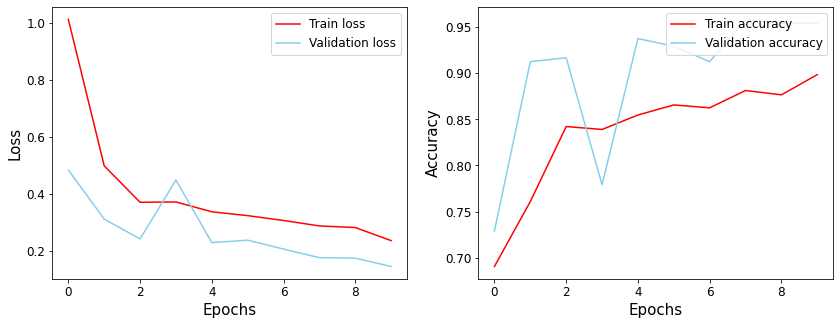

In [ ]:
acc_loss(hist2)

In [ ]:
acc2 = net2.evaluate(test_generator)

3/3 [==============================] - 1s 129ms/step - loss: 0.2715 - accuracy: 0.8375


In [ ]:
pred_2 = net2.predict(test_generator)

In [ ]:
pred_2 = np.argmax(pred_2, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, pred_2))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        40
           1       0.80      0.90      0.85        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



Text(0.5, 1.0, 'Confusion matrix')

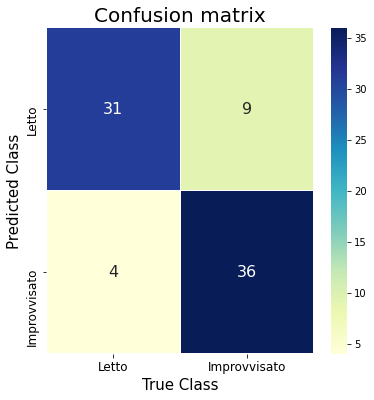

In [ ]:
cm = confusion_matrix(test_generator.classes, pred_2)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)

## CNN

Di seguito lasciamo una rete CNN costruita da 0. E' molto importante provare le performance di una rete più piccola sul nostro problema di classificazione poiché solitamente le reti pre-addestrate hanno bisogno di insiemi molto più grandi per performare al meglio mentre il nostro insieme non è così tanto grande. Definiamo quindi una rete "standard" fatta da 2 blocchi convoluzionali con relativo Pooling in cui alla fine è stato attaccato un layer denso con 124 neuroni. E' stato infine attaccato un layer di output con una funzione di attivazione softmax.

In [139]:
from keras import layers

In [140]:
model = keras.Sequential(
    [
     keras.Input(shape = (224,224,3)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Flatten(),
     layers.Dense(124, activation = "relu"),
     layers.Dropout(0.5),
     layers.Dense(2, activation = 'softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 124)               5785468   
_________________________________________________________________
dropout (Dropout)            (None, 124)               0

In [141]:
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

histo_best = model.fit(train_generator, 
                       epochs = 30, 
                       batch_size = 128, 
                       validation_data = validation_generator)

Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 0.7252 - accuracy: 0.5063 - val_loss: 16.9552 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 5s 5s/step - loss: 17.0436 - accuracy: 0.5000 - val_loss: 1.4897 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 5s 5s/step - loss: 2.3844 - accuracy: 0.5219 - val_loss: 4.0783 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 5s 5s/step - loss: 4.2834 - accuracy: 0.5016 - val_loss: 3.2379 - val_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 5s 5s/step - loss: 3.7814 - accuracy: 0.4953 - val_loss: 1.9943 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 5s 5s/step - loss: 2.4166 - accuracy: 0.5000 - val_loss: 0.9642 - val_accuracy: 0.5000
Epoch 7/30
1/1 [==============================] - 5s 5s/step - loss: 1.7778 - accuracy: 0.5031 - val_loss: 0.6802 - val_accuracy: 0.5375
Epoch 8/30
1/1 [=======================

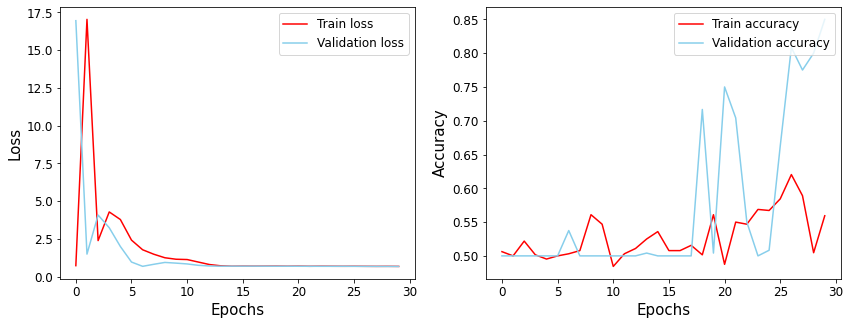

In [144]:
acc_loss(histo_best)

In [145]:
acc_best = model.evaluate(test_generator)

1/1 [==============================] - 1s 613ms/step - loss: 0.6736 - accuracy: 0.8375


Come si può notare le performance sul test set sono abbastanza buone. Stampiamo comunque di seguito sia il classification report che la confusion matrix per vedere effettivamente come sono le predizioni.

In [146]:
yc_pred = model.predict(test_generator)
y_pred_best = np.argmax(yc_pred, axis = 1)

In [147]:
print(classification_report(test_generator.classes, y_pred_best))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.85      0.82      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



Come si può notare i valori di f1-score sono molto alti ma comunque inferiori a quelli della MobileNet tagliata.

Text(0.5, 1.0, 'Confusion matrix')

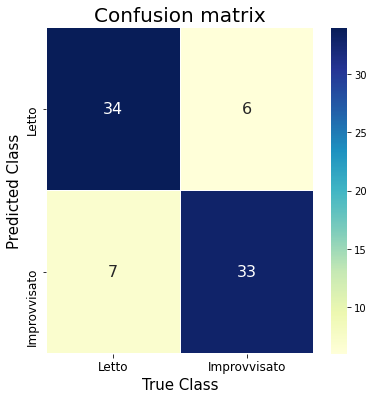

In [148]:
cm = confusion_matrix(test_generator.classes, y_pred_best)
fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)

# Demo

Di seguito proponiamo una demo in cui viene caricato un audio real time e si ha una classificazione da parte del miglior classificatore trovato in precedenza.

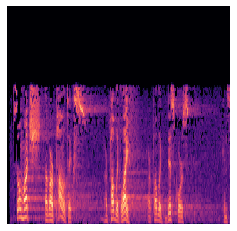

In [149]:
path = "gdrive/MyDrive/DigitalSignal/"
signal, sr = librosa.load(path + "prova8.mp3", duration= 7.0, sr=None) 
spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
S_dB = librosa.power_to_db(spect, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
fig.savefig(path + "single/test/"+"prova8.png", dpi = 100)

In [150]:
single_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

single_generator = single_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/single",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 1,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)
test,label_test = next(single_generator)

Found 1 images belonging to 1 classes.


In [151]:
test_features = model_1.predict(test)
test_features = test_features.reshape(test_features.shape[0],
                                      test_features.shape[1]*test_features.shape[2]*test_features.shape[3])

In [152]:
pred_finali = lr_1.predict(test_features)

In [153]:
pred_finali

array([0])

In [154]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in pred_finali]

predictions

['improvvisato']

In [155]:
prova_pred = model.predict(single_generator)
result = np.argmax(prova_pred, axis = 1)
result

array([1])

In [156]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in result]

In [157]:
predictions

['letto']

In [158]:
prova_pred

array([[0.49596626, 0.50403374]], dtype=float32)

In [159]:
train_generator.class_indices

{'improvvisato': 0, 'letto': 1}